# Three RCMS full historical period

31st October 2023

In [292]:
import pandas as pd
import gpflow
import sys
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code/guepard_repo/')
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code')
import guepard
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from utils.areal_plots import mean_ci_plots

## Data

In [293]:
dir = '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/'
df1 = pd.read_csv(
    dir + 'data/processed/hist_MPI_IITM-RegCM4-4.csv', index_col=0)
df2 = pd.read_csv(
    dir + 'data/processed/hist_MPI_REMO2009.csv', index_col=0)
df3 = pd.read_csv('data/processed/hist_CSIRO_IITM-RegCM4-4.csv', index_col=0)

In [294]:
df_list = []

for df in [df1, df2, df3]:
    if 'nb2' in list(df.columns):
        df = df[df['nb2']==0]
    if 'bnds' in list(df.columns):
        df = df[df['bnds'] == 0]
    df['time'] = pd.to_numeric(pd.to_datetime(df['time']))
    df['lat_group'] = pd.cut(df['lat'], 20, labels=np.arange(20))
    df['lon_group'] = pd.cut(df['lon'], 45, labels=np.arange(45))       
    gb = df.groupby(['lat_group', 'lon_group'])
    df_list.extend([gb.get_group(x)[['time', 'lon', 'lat', 'tp']].values for x in gb.groups])    

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_35842/3613481800.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_numeric(pd.to_datetime(df['time']))
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_35842/3613481800.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat_group'] = pd.cut(df['lat'], 20, labels=np.arange(20))
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_35842/3613481800.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

In [295]:
arr = np.array(df_list)

In [296]:
arr.shape

(2700, 1440, 4)

In [297]:
in_list= []
in_arr_raw = arr[:, :, 0:3]
input_scaler = StandardScaler()
input_scaler.fit(in_arr_raw.reshape(-1, 3))
for i in range(len(arr)):
    in_arrs = input_scaler.transform(in_arr_raw[i])
    in_list.append(in_arrs)
in_arr = np.array(in_list)

In [298]:
out_arr_tr, lmbd = boxcox(arr[:, :, 3].reshape(-1)+0.001)
#df['tp_tr'] = out_arr_tr

In [299]:
output_scaler = StandardScaler()
output_scaler.fit(out_arr_tr.reshape(-1, 1))
out_arr_flat = output_scaler.transform(out_arr_tr.reshape(-1, 1))
out_arr = out_arr_flat.reshape(arr.shape[0], arr.shape[1], 1,)

In [300]:
out_arr.shape

(2700, 1440, 1)

## Model

In [301]:
# seperate x and y
# num_split = 150

# list of num_split np.arrays
# Xl = np.array_split(in_arr[:129600], num_split)
# Yl = np.array_split(out_arr[:129600], num_split)

kernel = gpflow.kernels.Matern32()
noise_var = 0.01

In [305]:
# list of num_split GPR models
submodels = guepard.utilities.get_gpr_submodels(
    zip(in_arr[:40], out_arr[:40]), kernel, noise_variance=noise_var)

In [306]:
m_rbcm = guepard.baselines.Ensemble(
    models=submodels, method=guepard.baselines.EnsembleMethods.RBCM, weighting=guepard.baselines.WeightingMethods.VAR)

In [307]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_rbcm.training_loss,
                        m_rbcm.trainable_variables, options=dict(maxiter=100))
gpflow.utilities.print_summary(m_rbcm)

╒═════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ Ensemble.kernel.variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.30625 │
│ Ensemble.models[0].kernel.variance      │           │                  │         │             │         │         │          │
│ Ensemble.models[1].kernel.variance      │           │                  │         │             │         │         │          │
│ Ensemble.models[2].kernel.variance      │           │                  │         │             │         │         │          │
│ Ensemble.models[3].kernel.variance      │           │                  │         │      

In [310]:
#remove duplicate rows
x_plot = np.unique(in_arr[:40].reshape(-1, 3), axis=0)
x_plot.shape

(57600, 3)

In [311]:
ypred, var = m_rbcm.predict_y(x_plot)
arr= np.stack((ypred.numpy().flatten(), var.numpy().flatten()), axis=1)

In [312]:
df_temp= pd.DataFrame(arr, columns=['pred0', 'var0'])

In [313]:
input_loc_arr = input_scaler.inverse_transform(np.array(x_plot).reshape(-1, 3))

In [314]:
# Create dataframe, apply inverse transform and calculate 95th percentile CI
df_temp['y_pred'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values.reshape(-1, 1), lmbd))
df_temp['95th_u'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values.reshape(-1, 1) + 1.96 * np.sqrt(df_temp['var0'].values.reshape(-1, 1)), lmbd))
df_temp['95th_l'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values.reshape(-1, 1) - 1.96 * np.sqrt(df_temp['var0'].values.reshape(-1, 1)), lmbd))
df_temp['CI'] = df_temp['95th_u'].fillna(0) - df_temp['95th_l'].fillna(0)

df_temp[['time', 'lon', 'lat']] = input_loc_arr
df_temp.set_index(['time', 'lon', 'lat'], inplace=True)

df_temp[['y_pred', '95th_u', '95th_l', 'CI']] = df_temp[[
    'y_pred', '95th_u', '95th_l', 'CI']].fillna(0)

In [315]:
df_temp.to_csv('data/outputs/rbcm_tr_3rcm_1961_1965.csv')

In [316]:
df_temp

pred0      var0    y_pred     95th_u    95th_l  \
time         lon   lat                                                        
1.893024e+17 60.25 20.25  0.090791  1.053866  1.794873   8.976318  0.181479   
                   20.75  0.090694  1.053866  1.794708   8.975731  0.181457   
             60.75 20.25  0.093976  1.053864  1.800320   8.995648  0.182203   
                   20.75  0.093879  1.053864  1.800153   8.995056  0.182181   
             61.25 20.25  0.097446  1.053861  1.806269   9.016745  0.182996   
...                            ...       ...       ...        ...       ...   
1.133395e+18 98.75 20.75  0.458767  1.053861  2.517297  11.435932  0.288430   
             99.25 20.25  0.457349  1.053864  2.514129  11.425560  0.287916   
                   20.75  0.457237  1.053864  2.513879  11.424742  0.287876   
             99.75 20.25  0.455837  1.053866  2.510754  11.414507  0.287369   
                   20.75  0.455727  1.053866  2.510508  11.413700  0.287330   

                                 CI  
time         lon   lat               
1.893024e+17 60.25 20.25   8.794840  
                   20.75   8.794274  
             60.75 20.25   8.813445  
                   20.75   8.812875  
             61.25 20.25   8.833749  
...                             ...  
1.133395e+18 98.75 20.75  11.147502  
             99.25 20.25  11.137643  
                   20.75  11.136866  
             99.75 20.25  11.127138  
                   20.75  11.126371  

[57600 rows x 6 columns]

In [317]:
# To Data Array
ds = df_temp.to_xarray()
#ds['time'] = ds['time'].astype('datetime64[ns]')
ds

<xarray.Dataset>
Dimensions:  (time: 360, lon: 80, lat: 2)
Coordinates:
  * time     (time) float64 1.893e+17 1.92e+17 1.945e+17 ... 1.131e+18 1.133e+18
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 98.25 98.75 99.25 99.75
  * lat      (lat) float64 20.25 20.75
Data variables:
    pred0    (time, lon, lat) float64 0.09079 0.09069 0.09398 ... 0.4558 0.4557
    var0     (time, lon, lat) float64 1.054 1.054 1.054 ... 1.054 1.054 1.054
    y_pred   (time, lon, lat) float64 1.795 1.795 1.8 1.8 ... 2.514 2.511 2.511
    95th_u   (time, lon, lat) float64 8.976 8.976 8.996 ... 11.42 11.41 11.41
    95th_l   (time, lon, lat) float64 0.1815 0.1815 0.1822 ... 0.2874 0.2873
    CI       (time, lon, lat) float64 8.795 8.794 8.813 ... 11.14 11.13 11.13

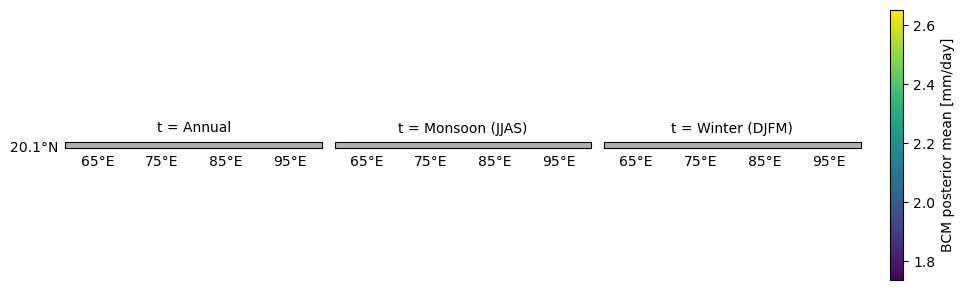

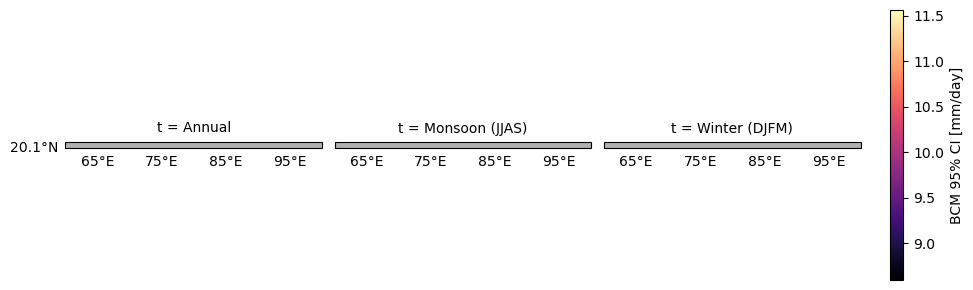

In [318]:
mean_ci_plots(ds)